# Loading

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import literal_evaluate, horizontal
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import re
from itertools import chain
from nltk import ngrams
import networkx as nx
import matplotlib.cm as cm

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from collections import Counter

nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

plt.style.use("ggplot")

# steam_reviews = pd.read_csv("data/steam_reviews.csv")

2024-12-05 04:12:14.375 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-05 04:12:14.380 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-05 04:12:14.384 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-05 04:12:14.387 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\jie22\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jie22\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jie22\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package 

In [2]:
from utils import load_steam_reviews
steam_reviews = load_steam_reviews()

2024-12-05 04:31:38.304 
  command:

    streamlit run c:\HW\Fall_2024_MSU\CMSE830\Homework\conman\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-12-05 04:31:38.307 No runtime found, using MemoryCacheStorageManager


# Feature Engineering

In [3]:
import requests
import contractions

def perform_feature_engineering(steam_reviews: pd.DataFrame) -> pd.DataFrame:
    def clean_text(text):
        text = text.lower() # lowercasing
        text = re.sub(r'http\S+', '', text) # Removing URL links
        text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphanumeric
        return text

    steam_reviews['clean_review'] = steam_reviews['review'].apply(lambda x: clean_text(str(x)))
    steam_reviews['clean_tokenized_review'] = steam_reviews['clean_review'].apply(lambda x: word_tokenize(str(x)))

    
    # NLTK's stopword list is quite limited, not containing many common words such as "like". This user generated list is more complete; it itself is a conglomeration of
    # several other stopword listings by recommendation from other users.
    stopword_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
    stopword_list = set(stopword_list.decode().splitlines())
    lemmatizer = WordNetLemmatizer()
    def clean_tokens(tokens):
        expanded_tokens = []
        for word in tokens:
            expanded_words = contractions.fix(word).split() # Expand contractions
            expanded_tokens.extend(expanded_words)
        tokens = expanded_tokens
        tokens = [word for word in tokens if word not in stopword_list] # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens] # Lemmatize
        return tokens

    steam_reviews['even_cleaner_tokenized_review'] = steam_reviews['clean_tokenized_review'].apply(clean_tokens)
    steam_reviews['review_text_length'] = steam_reviews['review'].apply(lambda x: len(str(x)))
    steam_reviews['review_total_words'] = steam_reviews['review'].apply(lambda x: len(word_tokenize(str(x))))
    steam_reviews['review_total_sentences'] = steam_reviews['review'].apply(lambda x: len(sent_tokenize(str(x))))
    return steam_reviews
steam_reviews = perform_feature_engineering(steam_reviews)

In [ ]:
# steam_reviews.to_csv("data/engineered_steam_reviews.csv", index=False)

# Basic Statistics

In [4]:
steam_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 120240 to 248469
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   app_id                          20000 non-null  int64  
 1   name                            20000 non-null  object 
 2   review_id                       20000 non-null  int64  
 3   language                        20000 non-null  object 
 4   review                          20000 non-null  object 
 5   timestamp_created               20000 non-null  int64  
 6   timestamp_updated               20000 non-null  int64  
 7   recommended                     20000 non-null  bool   
 8   votes_helpful                   20000 non-null  int64  
 9   votes_funny                     20000 non-null  int64  
 10  weighted_vote_score             20000 non-null  float64
 11  comment_count                   20000 non-null  int64  
 12  steam_purchase                 

In [5]:
horizontal([steam_reviews.describe(), steam_reviews[['name', 'language', 'review', 'recommended', 'steam_purchase', 'received_for_free', 'written_during_early_access']].describe()])
steam_reviews.head()

,app_id,name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,clean_review,clean_tokenized_review,even_cleaner_tokenized_review,review_text_length,review_total_words,review_total_sentences
120240,431960,Wallpaper Engine,76150570,english,good,1600397555,1600397555,True,1,0,...,544.0,0.0,401.0,1.607743e+09,good,[good],[good],4,1,1
63370,72850,The Elder Scrolls V: Skyrim,28700477,english,this game is bad lol,1482818470,1482818470,False,4,0,...,1899.0,0.0,1294.0,1.493446e+09,this game is bad lol,"[this, game, is, bad, lol]","[game, bad, lol]",20,5,1
43543,281990,Stellaris,53126889,english,Have put over 700 hours into this game,1562065913,1562065913,True,0,0,...,69830.0,2895.0,45021.0,1.611140e+09,have put over hours into this game,"[have, put, over, hours, into, this, game]","[hour, game]",38,8,1
264602,359550,Tom Clancy's Rainbow Six Siege,20305307,english,I would request a refund if this game wouldnt ...,1451943471,1582990733,False,0,0,...,3597.0,0.0,1832.0,1.583069e+09,i would request a refund if this game wouldnt ...,"[i, would, request, a, refund, if, this, game,...","[request, refund, game, extremely, long, unloc...",581,119,8
6797,48700,Mount & Blade: Warband,65498833,english,good game,1584820520,1584820520,False,4,4,...,9037.0,0.0,5375.0,1.601006e+09,good game,"[good, game]","[good, game]",9,2,1


In [6]:
def plot_correlation_heatmap() -> go.Figure:
    corr_matrix = steam_reviews.select_dtypes(include=['number', 'bool']).drop(['app_id', 'review_id', 'author_steamid'], axis=1).corr()
    corr_matrix = np.round(corr_matrix, 2)

    fig = px.imshow(
        corr_matrix,
        text_auto=True, 
        color_continuous_scale='RdBu_r',
        zmin=-1,
        zmax=1,
        aspect="auto"
    )
    
    fig.update_layout(
        title='Correlation heatmap',
        width=700,
        height=700,
        margin=dict(l=150, r=120, t=100, b=150)
    )
    
    return fig

fig = plot_correlation_heatmap()
fig.show()

# Review Text Analysis

First examining simple metrics such as total characters, total words, and total sentences per review to get an idea of the length distributions.

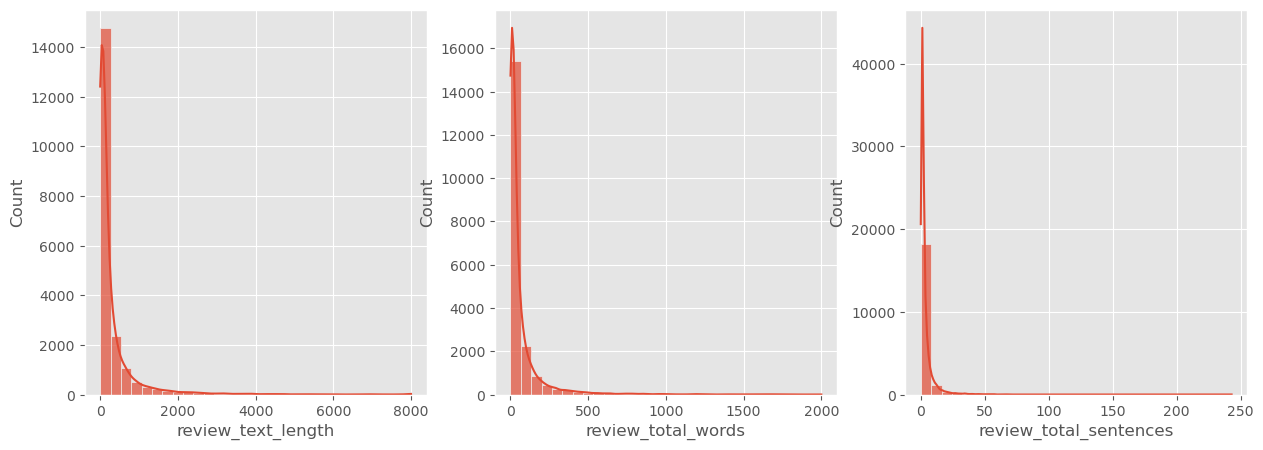

In [7]:
def plot_review_length_distributions() -> plt.Figure:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.histplot(steam_reviews['review_text_length'], kde=True, bins=30, alpha=0.7, ax=axes[0])
    sns.histplot(steam_reviews['review_total_words'], kde=True, bins=30, alpha=0.7, ax=axes[1])
    sns.histplot(steam_reviews['review_total_sentences'], kde=True, bins=30, alpha=0.7, ax=axes[2])

    return fig
_ = plot_review_length_distributions()

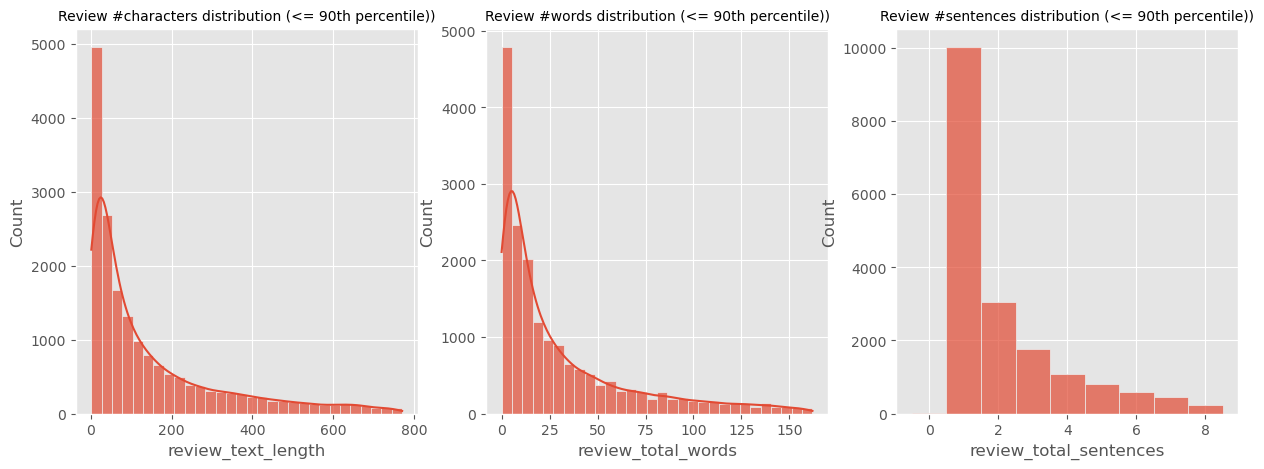

In [6]:
def plot_review_length_distributions_with_threshold(threshold_percentage: float = 0.10) -> plt.Figure:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    threshold_percentage = 0.10
    rank_threshold = int(steam_reviews.__len__() * threshold_percentage)

    sorted_text_length = steam_reviews['review_text_length'].sort_values(ascending=False)
    sorted_word_count = steam_reviews['review_total_words'].sort_values(ascending=False)
    sorted_sentence_count = steam_reviews['review_total_sentences'].sort_values(ascending=False)

    filtered_text_length = sorted_text_length.iloc[rank_threshold:]
    filtered_word_count = sorted_word_count.iloc[rank_threshold:]
    filtered_sentence_count = sorted_sentence_count.iloc[rank_threshold:]

    sns.histplot(filtered_text_length, kde=True, bins=30, alpha=0.7, ax=axes[0])
    axes[0].set_title("Review #characters distribution (<= 90th percentile))", fontsize=10)

    sns.histplot(filtered_word_count, kde=True, bins=30, alpha=0.7, ax=axes[1])
    axes[1].set_title("Review #words distribution (<= 90th percentile))", fontsize=10)

    sns.histplot(filtered_sentence_count, discrete=True, alpha=0.7, ax=axes[2])
    axes[2].set_title("Review #sentences distribution (<= 90th percentile))", fontsize=10)

    return fig
_ = plot_review_length_distributions_with_threshold()
    

Filtered or not, our distributions are heavily skewed to the right, with a quick dropoff and long tail distribution. Evidently, most reviews are relatively short.
- While most users leave very concise reviews, some are highly detailed in their feedback.

Though all three distributions all showcase a similar metric, we can gleam different insight from each:
- The distribution of review length by character gives us a very smooth curve. This tells us that our dropoff is rather consistent.
- The distribution of review length by words gives us further information, most reviews contain 20 or fewer words, with there being slight peaks and valleys in this distribution.
- The distribution of review length by sentence gives us our best metric in terms of conciseness and relatability. Most reviews are one or two sentences.

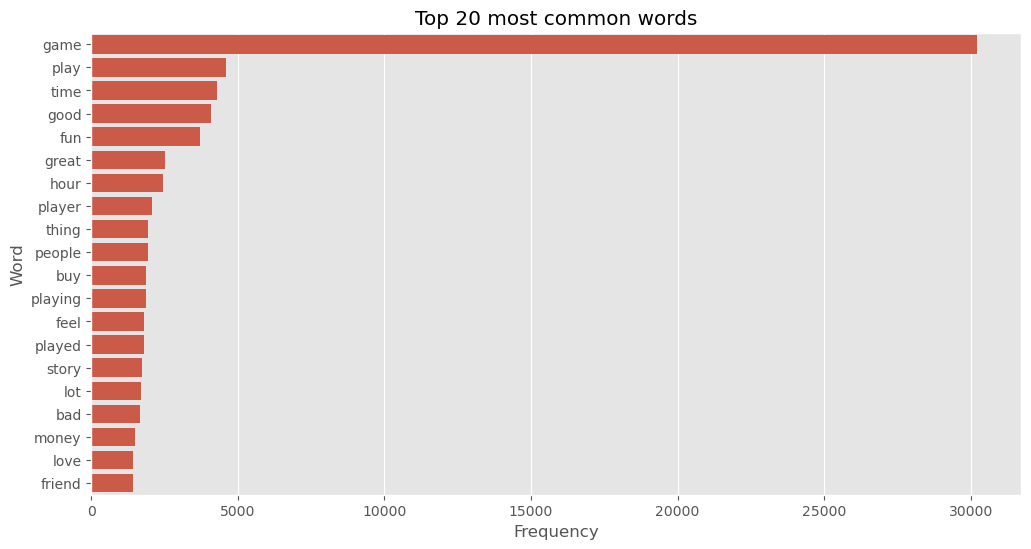

In [7]:
# Word frequency analysis:
def plot_most_common_n_words(n: int = 20) -> plt.Figure:
    all_tokens = list(chain.from_iterable(steam_reviews['even_cleaner_tokenized_review']))
    freq_dist = FreqDist(all_tokens)

    n = 20
    top_n_words = freq_dist.most_common(n)
    top_n_words = pd.DataFrame(top_n_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data = top_n_words,
        x = 'Frequency',
        y = 'Word',
        orient = 'h'
    )
    plt.title(f"Top {n} most common words")
    return plt.gcf()
_ = plot_most_common_n_words()

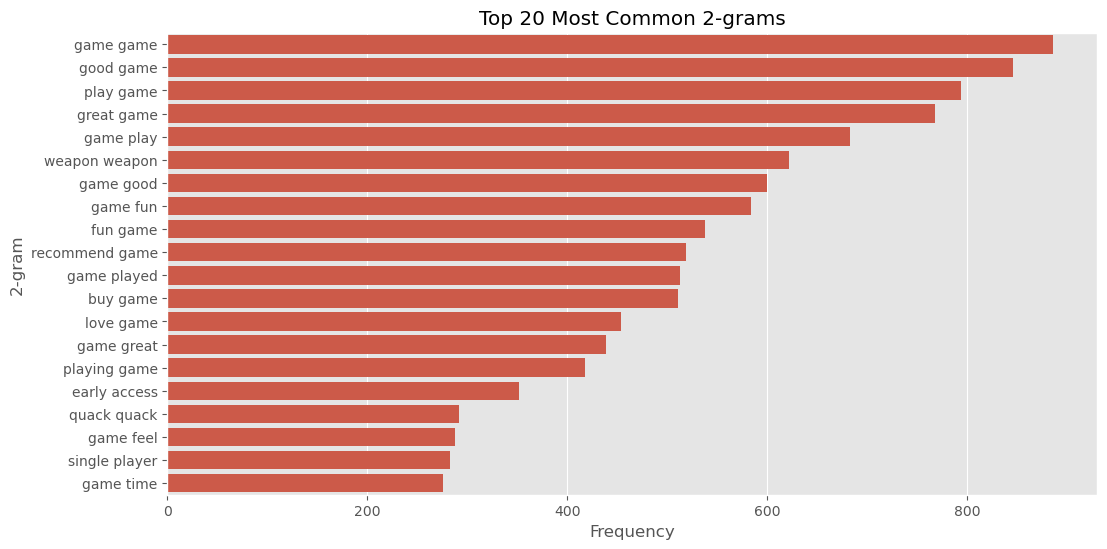

In [8]:
def plot_top_n_bigram_frequencies(n = 20) -> plt.Figure:
    all_tokens = list(chain.from_iterable(steam_reviews['even_cleaner_tokenized_review']))

    n = 2
    n_grams = list(ngrams(all_tokens, n))
    freq_dist_ngrams = FreqDist(n_grams)

    top_n_ngrams = freq_dist_ngrams.most_common(20)

    # Convert to DataFrame for plotting
    top_n_ngrams_df = pd.DataFrame(top_n_ngrams, columns=['ngram', 'frequency'])
    top_n_ngrams_df['ngram'] = top_n_ngrams_df['ngram'].apply(lambda x: ' '.join(x))  # Convert tuples to strings

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_n_ngrams_df,
        x='frequency',
        y='ngram',
        orient='h'
    )
    plt.title(f'Top 20 Most Common {n}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    return plt.gcf()
_ = plot_top_n_bigram_frequencies()

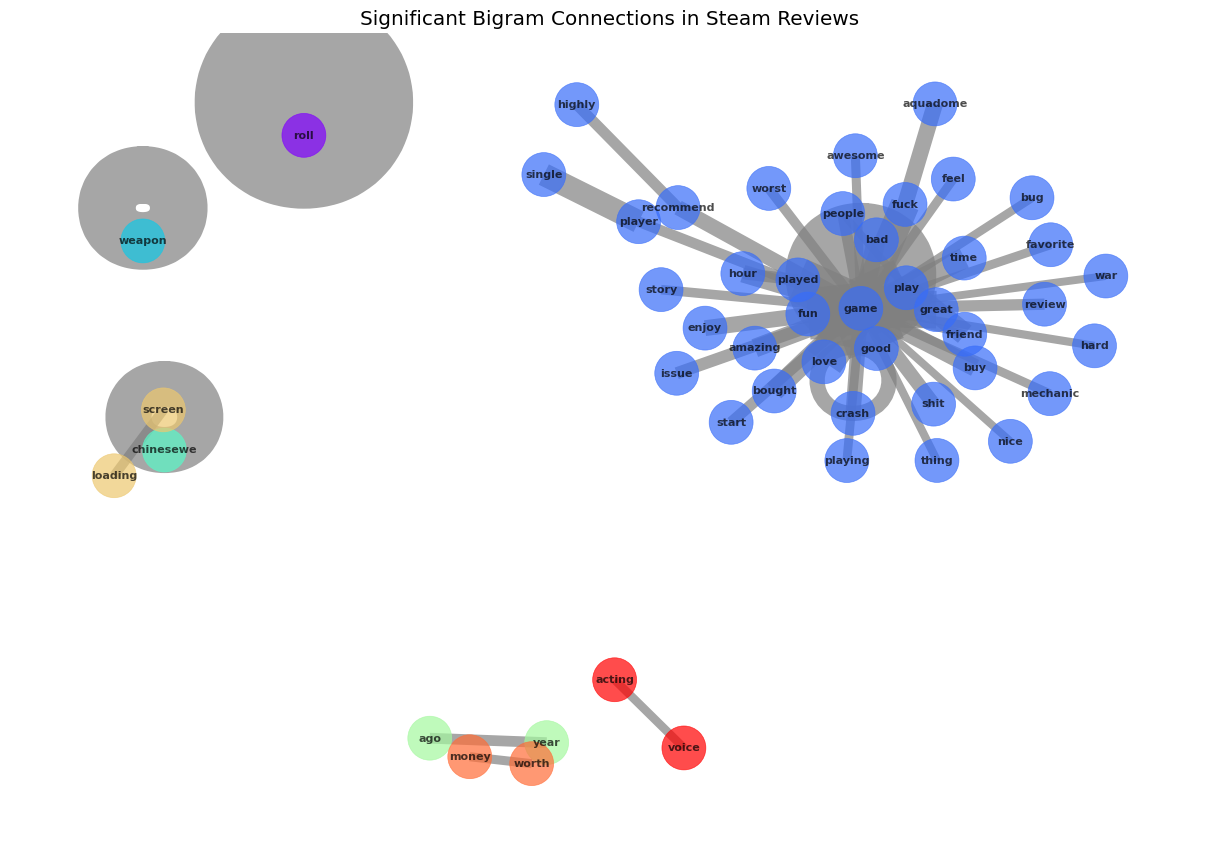

In [10]:
# Uses some borrowed functions from a previous ICA to plot a bigram word network
def plot_bigram_word_network() -> plt.Figure:
    def create_network_visualization(bigrams, min_freq=2, max_edges=50) -> nx.Graph:
        G = nx.Graph() # Initialize a graph object
        
        for (w1, w2), freq in bigrams.items(): # Add edges
            if freq >= min_freq:
                G.add_edge(w1, w2, weight=freq)
        
        if len(G.edges()) > max_edges: # Limit to most significant connections to avoid over cluttering
            significant_edges = sorted(G.edges(data=True), 
                                    key=lambda x: x[2]['weight'], 
                                    reverse=True)[:max_edges]
            G = nx.Graph()
            for w1, w2, data in significant_edges:
                G.add_edge(w1, w2, weight=data['weight'])
        
        return G

    def plot_word_network(G):
        plt.figure(figsize=(12, 8))

        # Tested multiple different layouts, these were the best configurations, each with their own merit
        # pos = nx.planar_layout(G, scale=1.3)
        # pos = nx.arf_layout(G, a=1.5, max_iter = 100)
        pos = nx.spring_layout(G, k=2.5, iterations=70, scale=1)

        thickness_weight = 1 / 15  # Multiplying by a scalar adjust the edge thickness
        edge_weights = [G[u][v]["weight"] * thickness_weight for u, v in G.edges()]

        
        clusters = list(nx.connected_components(G))
        colors = cm.rainbow(np.linspace(0, 1, len(clusters))) 

        # Coloring clusters to make things a bit easier to differentiate
        node_color_map = {}
        for color, cluster in zip(colors, clusters):
            for node in cluster:
                node_color_map[node] = color

        node_colors = [node_color_map[node] for node in G.nodes()]

        # Plot
        nx.draw(G, pos,
                node_color=node_colors,
                node_size=1000,
                font_size=8,
                font_weight='bold',
                width=edge_weights,
                with_labels=True,
                edge_color='gray',
                alpha=0.7)

        plt.title("Significant Bigram Connections in Steam Reviews")
        return plt.gcf()

    all_tokens = list(chain.from_iterable(steam_reviews['even_cleaner_tokenized_review']))
    n_grams = list(ngrams(all_tokens, 2))
    freq_dist_ngrams = FreqDist(n_grams)

    G = create_network_visualization(freq_dist_ngrams, min_freq=2, max_edges=50)
    fig = plot_word_network(G)
    return fig
_ = plot_bigram_word_network()

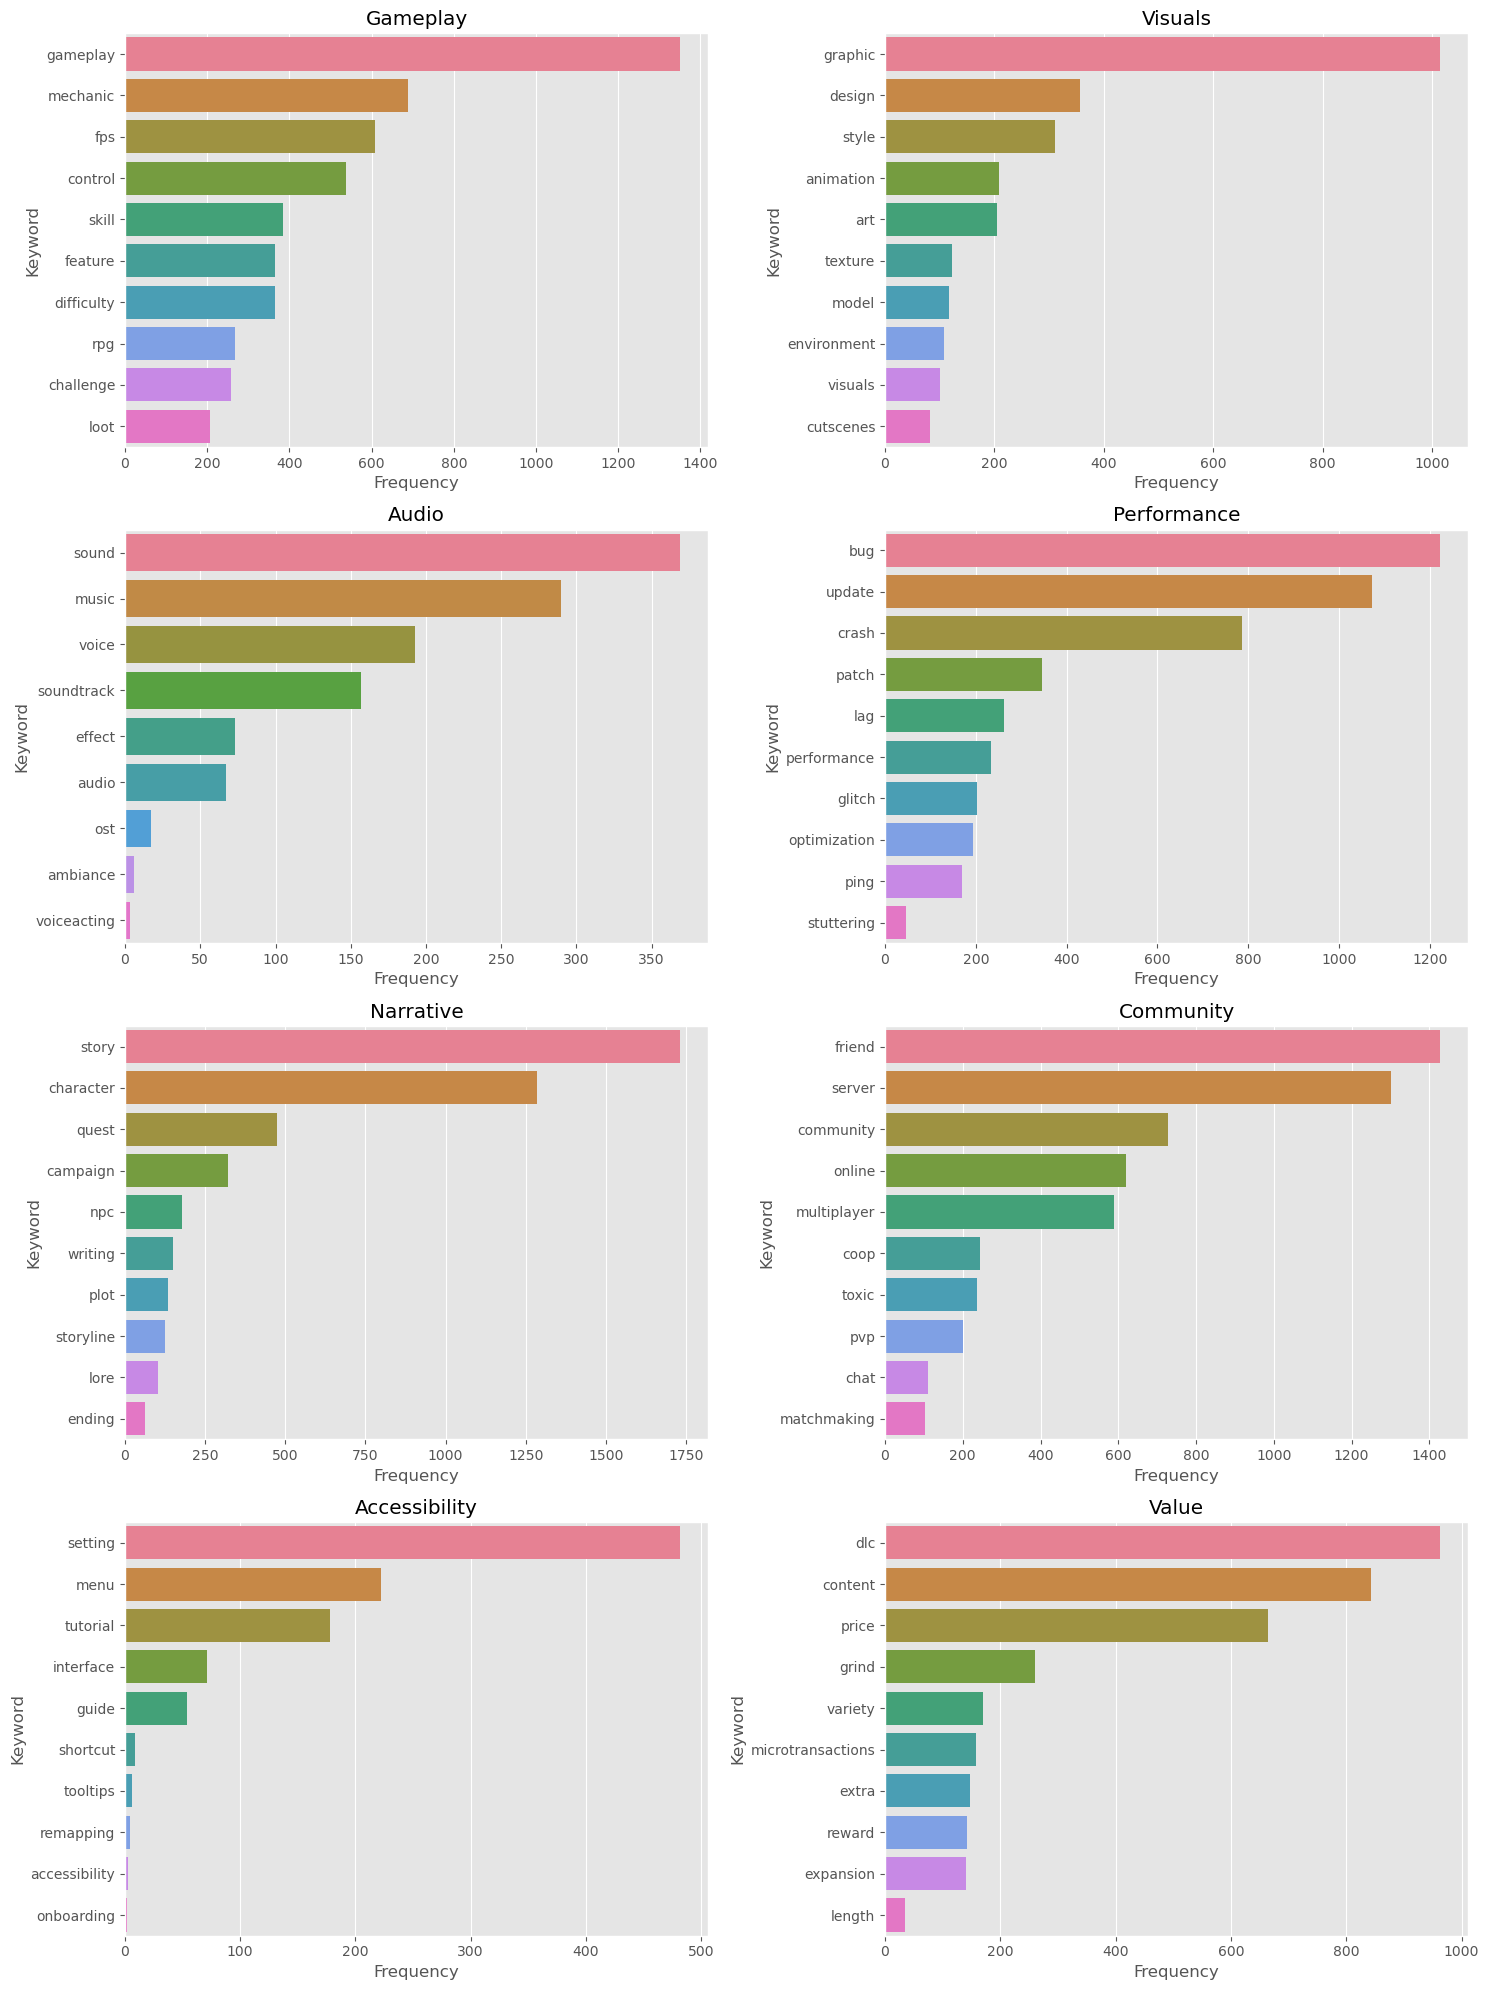

In [33]:
# These category wide keywords were created with the help of ChatGPT-4o on 12/3/24
# After creation of general keywords, we manually edited the listings for consistency, as well as added a few more game specific labels like "fps", "ost", "ui", "toxic" etc.
# Using https://gametree.me/gaming-terms/ as a reference
categories = {
    'Gameplay': [
        'gameplay', 'mechanics', 'controls', 'difficulty', 'balance', 'replayability',
        'progression', 'challenges', 'objectives', 'customization', 'levelling',
        'features', 'interaction', 'immersion', 'skills', 'pacing', 'grinding',
        'buff', 'nerf', 'op', 'meta', 'loot', 'skilltree', 'easteregg', 'camping',
        'dps', 'rpg', 'mmorpg', 'fps', 'ez'
    ],
    'Visuals': [
        'graphics', 'visuals', 'art', 'design', 'style', 'animation', 'environment',
        'lighting', 'textures', 'resolution', 'shaders', 'models', 'aesthetics',
        'realism', 'colors', 'visualfidelity', 'hud', 'ui', 'cutscenes'
    ],
    'Audio': [
        'music', 'soundtrack', 'audio', 'sound', 'effects', 'voice', 'ambiance',
        'backgroundmusic', 'sounddesign', 'narration', 'thememusic', 'voiceacting',
        'volumebalance', 'ost'
    ],
    'Performance': [
        'performance', 'optimization', 'framerate', 'bugs', 'glitches', 'crashes',
        'lag', 'latency', 'loadingtimes', 'stuttering', 'fps', 'systemrequirements',
        'compatibility', 'updates', 'patches', 'ping', 'framedrops', 'inputlag'
    ],
    'Narrative': [
        'story', 'plot', 'characters', 'lore', 'writing', 'quests',
        'storyline', 'campaign', 'worldbuilding', 'backstory',
        'characterdevelopment', 'narrativepacing', 'endings', 'twists', 'npc', 'sidequests'
    ],
    'Community': [
        'multiplayer', 'online', 'coop', 'community', 'friends', 'matchmaking',
        'social', 'guilds', 'chat', 'servers', 'forums',
        'playerbase', 'leaderboards', 'clans', 'competition', 'pvp', 'toxic',
        'esports', 'teamwork'
    ],
    'Accessibility': [
        'accessibility', 'interface', 'subtitles', 'tutorials', 'difficultymodes',
        'settings', 'colorblindmode', 'adjustability', 'menus',
        'shortcuts', 'tooltips', 'guides', 'userfriendly', 'onboarding', 'remapping',
        'assistmode'
    ],
    'Value': [
        'price', 'value', 'content', 'dlc', 'expansions',
        'microtransactions', 'rewards', 'unlockables', 'length',
        'longevity', 'variety', 'bundles', 'extras', 'paytowin',
        'freemium', 'grind'
    ]
}

def plot_common_words_by_category() -> plt.Figure:
    lemmatizer = WordNetLemmatizer()
    assigned_keywords = {} # Creating a dictionary of assigned keywords per category
    for category, keywords in categories.items():
        unique_keywords = []
        for word in keywords:
            if word not in assigned_keywords:
                assigned_keywords[word] = category
                unique_keywords.append(word)
        categories[category] = unique_keywords

    # To remain consistent with the lemmatized tokens of our cleaned reviews, we need to also lemmatize our category words
    lemmatized_categories = {
        category: [lemmatizer.lemmatize(word.lower()) for word in words]
        for category, words in categories.items()
    }

    # Reverse mapping from keyword to category
    keyword_to_category = {}
    for category, keywords in lemmatized_categories.items():
        for keyword in keywords:
            keyword_to_category[keyword] = category

    # Initialize counters for each category
    category_keyword_counts = {category: Counter() for category in categories}

    all_tokens = list(chain.from_iterable(steam_reviews['even_cleaner_tokenized_review']))

    # Count frequencies of keywords, ensuring no overlap
    for word in all_tokens:
        lemma_word = lemmatizer.lemmatize(word.lower())
        category = keyword_to_category.get(lemma_word)
        if category:
            category_keyword_counts[category][lemma_word] += 1

    top_keywords_per_category = {}
    for category, counter in category_keyword_counts.items():
        top_keywords = counter.most_common(10)  # Adjust the number as needed
        top_keywords_per_category[category] = top_keywords

    data = []
    for category, keywords in top_keywords_per_category.items():
        for word, count in keywords:
            data.append({'Category': category, 'Keyword': word, 'Frequency': count})

    df = pd.DataFrame(data)

    # Plot
    categories_list = list(categories.keys())
    num_categories = len(categories_list)
    fig, axes = plt.subplots(nrows=(num_categories + 1) // 2, ncols=2, figsize=(15, 20))
    axes: list[plt.Axes] = axes.ravel()

    for i, category in enumerate(categories_list):
        ax = axes[i]
        category_data = df[df['Category'] == category]
        sns.barplot(
            data=category_data,
            x='Frequency', y='Keyword',
            ax=ax,
            hue='Keyword',
            legend=False,
        )
        ax.set_title(category)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Keyword')
    plt.tight_layout()
    return fig
_ = plot_common_words_by_category()

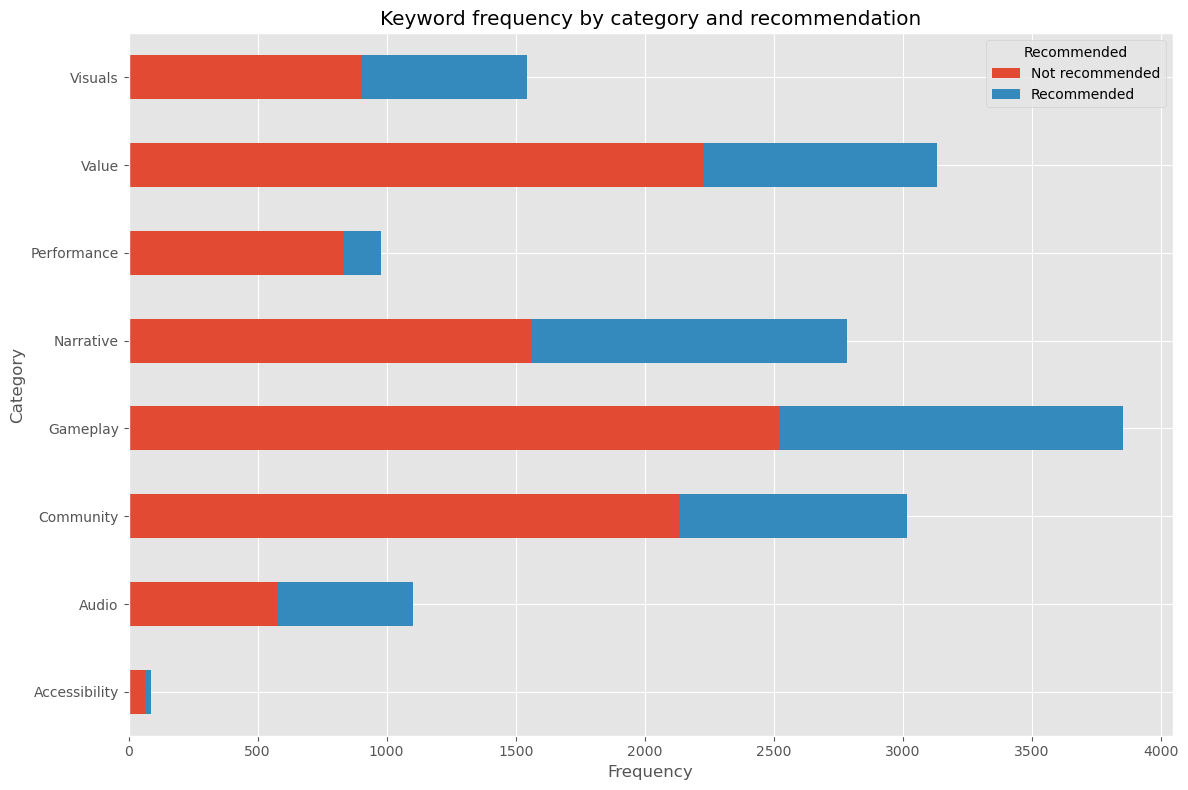

In [36]:
def plot_common_words_by_category_stacked() -> plt.Figure:
    lemmatizer = WordNetLemmatizer()
    keyword_to_category = {
        keyword: category
        for category, keywords in categories.items()
        for keyword in keywords
    }
    counters = {
        True: {category: Counter() for category in categories},
        False: {category: Counter() for category in categories}
    }
    for _, row in steam_reviews.iterrows():
        tokens = row['even_cleaner_tokenized_review']
        recommended = row['recommended']
        for token in tokens:
            lemma_word = lemmatizer.lemmatize(token.lower())
            category = keyword_to_category.get(lemma_word)
            if category:
                counters[recommended][category][lemma_word] += 1

    # Putting counts into dataframe
    plot_data = []
    for recommended, category_data in counters.items():
        for category, keyword_counts in category_data.items():
            for keyword, count in keyword_counts.items():
                plot_data.append({
                    'Recommended': recommended,
                    'Category': category,
                    'Keyword': keyword,
                    'Frequency': count
                })

    plot_df = pd.DataFrame(plot_data)

    category_summary = plot_df.groupby(['Category', 'Recommended'])['Frequency'].sum().unstack()

    category_summary.plot(kind='barh', stacked=True, figsize=(12, 8))
    plt.title('Keyword frequency by category and recommendation')
    plt.xlabel('Frequency')
    plt.ylabel('Category')
    plt.legend(title='Recommended', labels=['Not recommended', 'Recommended'])
    plt.tight_layout()

    return plt.gcf()
_ = plot_common_words_by_category_stacked()


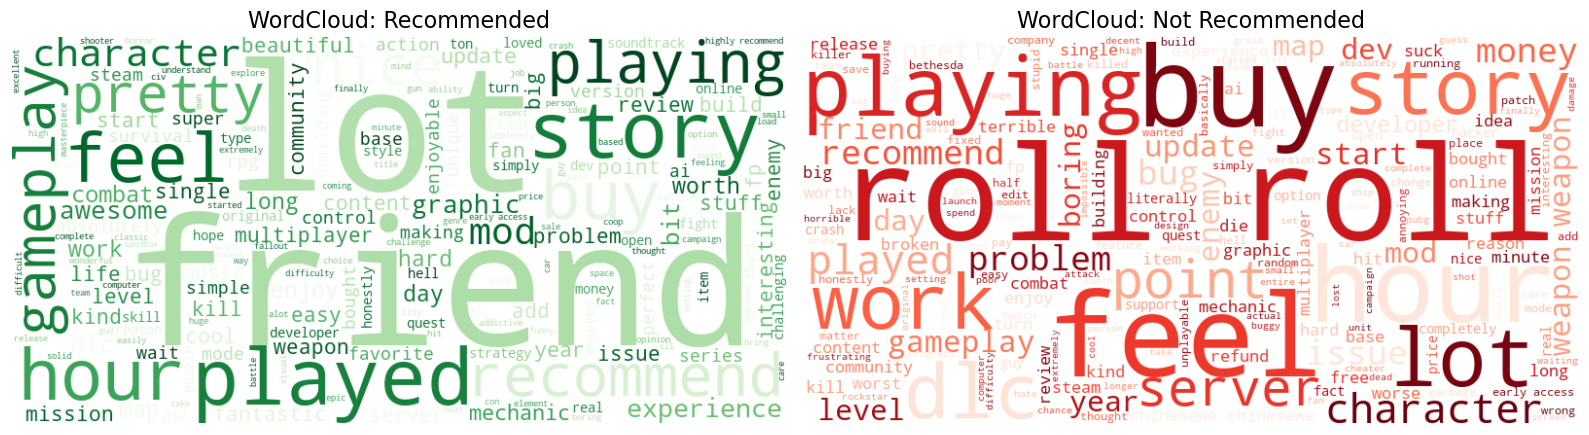

In [8]:

def plot_word_clouds():
    excluded_words = [
        "game",
        "good",
        "fucking",
        "shit",
        "play",
        "bad",
        "time",
        "fun",
        "great",
        "love",
        "amazing",
        "thing",
        "people",
        "fuck",
        "player"
    ]  # Add more words to exclude as needed, trying to exclude things like swear words from production

    def filter_tokens(tokens, excluded_words):
        return [word for word in tokens if word.lower() not in excluded_words]

    steam_reviews['filtered_tokens'] = steam_reviews['even_cleaner_tokenized_review'].apply(lambda tokens: filter_tokens(tokens, excluded_words))

    # Combining for word cloud usage
    true_text = ' '.join([' '.join(tokens) for tokens in steam_reviews[steam_reviews['recommended'] == True]['filtered_tokens']])
    false_text = ' '.join([' '.join(tokens) for tokens in steam_reviews[steam_reviews['recommended'] == False]['filtered_tokens']])

    true_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(true_text)
    false_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(false_text)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(true_wordcloud, interpolation='bilinear')
    axes[0].set_title("WordCloud: Recommended", fontsize=16)
    axes[0].axis('off')
    
    
    axes[1].imshow(false_wordcloud, interpolation='bilinear')
    axes[1].set_title("WordCloud: Not Recommended", fontsize=16)
    axes[1].axis('off')
    plt.tight_layout()
    
    return fig
_ = plot_word_clouds()

On the side of the recommended reviews, we see notable keywords like, story, friend, graphic, experience, gameplay, and monika.

On the side of not recommended reviews, we see keywords such as feel, server, bug, update, issue, story.

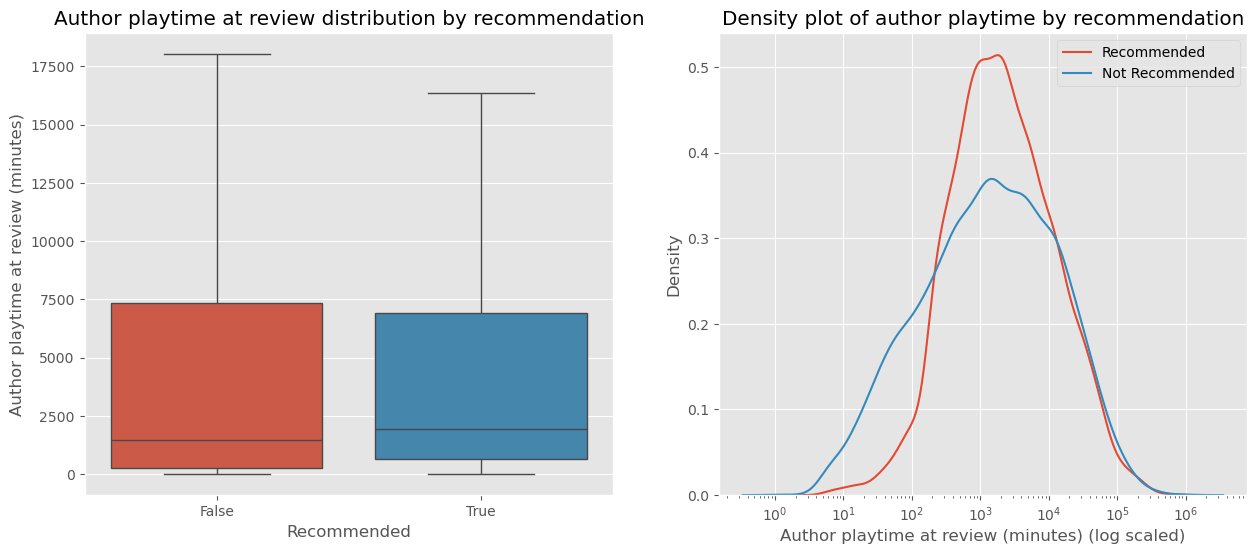

In [35]:
def plot_author_playtime_by_recommendation_distributions():
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes: list[plt.Axes] = axes
    sns.boxplot(
        data=steam_reviews,
        x="recommended",
        y="author_playtime_at_review",
        hue="recommended",
        legend=False,
        showfliers=False,
        ax=axes[0],
    )
    axes[0].set_title('Author playtime at review distribution by recommendation')
    axes[0].set_xlabel('Recommended')
    axes[0].set_ylabel('Author playtime at review (minutes)')

    sns.kdeplot(data=steam_reviews[steam_reviews['recommended'] == True], 
                x='author_playtime_at_review', label='Recommended', log_scale=True, ax=axes[1])
    sns.kdeplot(data=steam_reviews[steam_reviews['recommended'] == False], 
                x='author_playtime_at_review', label='Not Recommended', log_scale=True, ax=axes[1])
    axes[1].set_title('Density plot of author playtime by recommendation')
    axes[1].set_xlabel('Author playtime at review (minutes) (log scaled)')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    return fig
_ = plot_author_playtime_by_recommendation_distributions()

Here we draw two simple distribution graphs, a double boxplot on author playtime at review, and a kernel density estimate plot on log scaled author playtime at review.
- We use log scaling to account for our heavy skew to the right. We do indeed find better results in this scaling, we should however consider this is more exponential.

From the left graph, we can notice that authors that recommend a game typically have a higher amount of playtime than authors that do not.
- Intuitively, this aligns with the notion of, players who enjoy a game would typically play more, and players who do not enjoy a game may quit out earlier. They may not want to continue.
- From this we can draw insight: players with a lot to say typically enjoyed the game!

# Dashboard

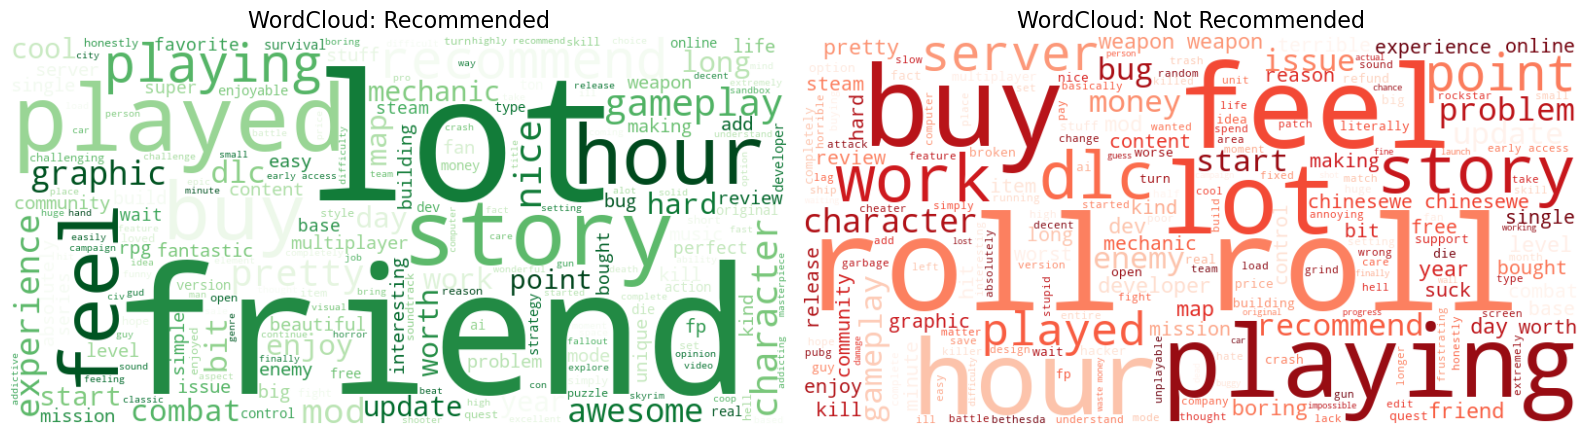

In [ ]:

def plot_word_clouds():
    excluded_words = [
        "game",
        "good",
        "fucking",
        "shit",
        "play",
        "bad",
        "time",
        "fun",
        "great",
        "love",
        "amazing",
        "thing",
        "people",
        "fuck",
        "player"
    ]  # Add more words to exclude as needed, trying to exclude things like swear words from production

    def filter_tokens(tokens, excluded_words):
        return [word for word in tokens if word.lower() not in excluded_words]

    steam_reviews['filtered_tokens'] = steam_reviews['even_cleaner_tokenized_review'].apply(lambda tokens: filter_tokens(tokens, excluded_words))

    # Combining for word cloud usage
    true_text = ' '.join([' '.join(tokens) for tokens in steam_reviews[steam_reviews['recommended'] == True]['filtered_tokens']])
    false_text = ' '.join([' '.join(tokens) for tokens in steam_reviews[steam_reviews['recommended'] == False]['filtered_tokens']])

    true_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(true_text)
    false_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(false_text)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(true_wordcloud, interpolation='bilinear')
    axes[0].set_title("WordCloud: Recommended", fontsize=16)
    axes[0].axis('off')
    
    
    axes[1].imshow(false_wordcloud, interpolation='bilinear')
    axes[1].set_title("WordCloud: Not Recommended", fontsize=16)
    axes[1].axis('off')
    plt.tight_layout()
    
    return fig
_ = plot_word_clouds()

In [ ]:
import pandas as pd
from collections import Counter

def find_associated_words(df, token_column, target_word, top_n=10):
    if not all(isinstance(tokens, list) for tokens in df[token_column]):
        raise ValueError(f"The column '{token_column}' must contain tokenized words as lists.")
    
    # Filter rows that contain the target word
    rows_with_target = df[df[token_column].apply(lambda tokens: target_word in tokens)]
    
    # Flatten
    all_words = [word for tokens in rows_with_target[token_column] for word in tokens if word != target_word]
    
    # Count common word associations
    word_counts = Counter(all_words)
    result_df = pd.DataFrame(word_counts.items(), columns=["Word", "Count"]).sort_values(by="Count", ascending=False)
    return result_df.head(top_n)

def plot_associated_words(word_counts_df, target_word):
    fig = px.bar(
        word_counts_df,
        x="Word",
        y="Count",
        title=f"Words commonly associated with '{target_word}'",
        labels={"Count": "Frequency", "Word": "Associated Word"},
        text="Count",
        color="Word",  # Use the "Word" column for coloring
        color_discrete_sequence=px.colors.qualitative.Plotly,
    )
    fig.update_traces(textposition="outside")
    fig.update_layout(xaxis_title="Associated Words", yaxis_title="Frequency", showlegend=False)
    fig.show()

word_counts_df = find_associated_words(steam_reviews, 'even_cleaner_tokenized_review', 'bad')
plot_associated_words(word_counts_df, 'bad')